In [4]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

# Results files reading and preprocessing

In [18]:
avgfp_results_dirs = [(2, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_2_avgfp_DecisionTreeRegressor"),
                      (3, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_3_avgfp_DecisionTreeRegressor"),
                      (4, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_4_avgfp_DecisionTreeRegressor"),
                      (5, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_5_avgfp_DecisionTreeRegressor"),
                      (6, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_6_avgfp_DecisionTreeRegressor"),
                      (7, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_7_avgfp_DecisionTreeRegressor"),
                      (8, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_8_avgfp_DecisionTreeRegressor"),
                      (9, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_9_avgfp_DecisionTreeRegressor"),
                      (10, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_10_avgfp_DecisionTreeRegressor"),
                      (2, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_2_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (3, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_3_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (4, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_4_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (5, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_5_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (6, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_6_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (7, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_7_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (8, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_8_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (9, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_9_avgfp_StandardScaler_DecisionTreeRegressor"),
                      (10, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_10_avgfp_StandardScaler_DecisionTreeRegressor")]
pabp_yeast_results_dirs = [(2, "DecisionTreeRegressor", "results/masking_experiments_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_2_PABP_YEAST_Fields2013_DecisionTreeRegressor"),
                           (2, "StandardScaler_DecisionTreeRegressor", "results/masking_experiments_StandardScaler_WeightedDecisionTree/masking_experiments_trainedwith_1_testedwith_2_PABP_YEAST_Fields2013_StandardScaler_DecisionTreeRegressor")]

results_dirs_dict = {"avgfp": avgfp_results_dirs, "PABP_YEAST_Fields2013": pabp_yeast_results_dirs}

In [19]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", 
             #"ProtVec"
             ]
global_masks = ["relative",
                "relativex2",
                "relativex10",
                "relativex100",
                "relativex1000",
                "relativex0.5",
                "relativex0.1",
                "shannon",
                "shannonx2",
                "shannonx10",
                "shannonx100",
                "shannonx1000",
                "shannonx0.5",
                "shannonx0.1",
                "lockless",
                "locklessx2",
                "locklessx10",
                "locklessx100",
                "locklessx1000",
                "locklessx0.5",
                "locklessx0.1",
                "1-shannon",
                "inverted_relative",
                "inverted_shannon",
                "inverted_lockless",
                "normalized_relative",
                "normalized_shannon",
                "normalized_lockless",
                "random"]
masks = global_masks
labeled_sizes_list = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.03, 0.01]

In [20]:
global_pred_dict = dict()

for dataset, results_dirs in results_dirs_dict.items():
    global_pred_dict[dataset] = dict()
    for variant_num, model, results_dir in results_dirs:
        global_pred_dict[dataset][(model, variant_num)] = dict()
        for enc in encodings:

            global_pred_dict[dataset][(model, variant_num)][enc] = dict()   
            for mask in masks:
                global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}'] = dict()

            for labeled_size in labeled_sizes_list:
                with open(f'{results_dir}/pred_dict_{enc}_{labeled_size}.pickle', 'rb') as f:
                    global_pred_dict[dataset][(model, variant_num)][enc][labeled_size] = pkl.load(f)
                for mask in masks:
                    with open(f'{results_dir}/pred_dict_{enc}_masked_{mask}_{labeled_size}.pickle', 'rb') as f:
                        global_pred_dict[dataset][(model, variant_num)][f'{enc}_masked_{mask}'][labeled_size] = pkl.load(f)

# Creation of the results dataframe

In [21]:
# Create results dataframe
results_df = pd.DataFrame(columns=['Dataset', 'Model', 'Train N variants', 'Test N variants', 'Labeled', 'Train_size', 'Encoding', 'MSE', 'Spearman_r', 'Weighted_tau'])
for dataset, variant_and_model in global_pred_dict.items():
    for (model, variant_num), encodings in variant_and_model.items():
            for encoding, labeled_sizes in encodings.items():
                for labeled_size, folds in labeled_sizes.items():
                    for fold, results in folds.items():
                        y_proba = results["y_proba"]
                        y_test = results["original_y_test"]
                        train_size = results["train_len"]
                        mse = mean_squared_error(y_test, y_proba)
                        rmse = np.sqrt(mse)
                        spearman_r = spearmanr(y_test, y_proba)[0]
                        weighted_tau = weightedtau(y_test, y_proba)[0]
                        if "double_masked" in encoding:
                            enc_value = encoding.split("_double_masked")[0]
                            mask_value = encoding.split("_double_masked_")[1]
                        elif "masked" in encoding:
                            enc_value = encoding.split("_masked")[0]
                            mask_value = encoding.split("_masked_")[1]
                        else:
                            enc_value = encoding
                            mask_value = "unmasked"
                        results_df = pd.concat([results_df, pd.DataFrame(
                                                        {'Dataset': dataset,
                                                        'Model': model,
                                                        'Train N variants': 1,
                                                        'Test N variants': variant_num,
                                                        'Labeled': labeled_size, 
                                                        'Train_size': train_size, 
                                                        'Encoding': enc_value,
                                                        'Mask': mask_value,
                                                        'MSE': mse,
                                                        'RMSE': rmse,
                                                        'Spearman_r': spearman_r,
                                                        'Weighted_tau': weighted_tau
                                                        }, index=[0])], ignore_index=True)

In [22]:
# Save results_dataframe to file
results_df.to_csv(f'results/masking_weighted_trees_analysis_results_dataframe.csv', index=False)

In [5]:
# Read results_dataframe from file
results_df = pd.read_csv(f'results/masking_weighted_trees_analysis_results_dataframe.csv')

In [6]:
results_df[(results_df["Dataset"] == "avgfp")]

Dataset                                 Model  Train N variants  \
0       avgfp                 DecisionTreeRegressor                 1   
1       avgfp                 DecisionTreeRegressor                 1   
2       avgfp                 DecisionTreeRegressor                 1   
3       avgfp                 DecisionTreeRegressor                 1   
4       avgfp                 DecisionTreeRegressor                 1   
...       ...                                   ...               ...   
51835   avgfp  StandardScaler_DecisionTreeRegressor                 1   
51836   avgfp  StandardScaler_DecisionTreeRegressor                 1   
51837   avgfp  StandardScaler_DecisionTreeRegressor                 1   
51838   avgfp  StandardScaler_DecisionTreeRegressor                 1   
51839   avgfp  StandardScaler_DecisionTreeRegressor                 1   

       Test N variants  Labeled  Train_size Encoding       MSE  Spearman_r  \
0                    2     1.00         970  One_hot  0.170758    0.689815   
1                    2     0.75         727  One_hot  0.245514    0.596832   
2                    2     0.50         485  One_hot  0.355177    0.487798   
3                    2     0.25         242  One_hot  0.534993    0.267361   
4                    2     0.10          97  One_hot  0.607619    0.222414   
...                ...      ...         ...      ...       ...         ...   
51835               10     0.25         242    ANN4D  2.722217    0.089871   
51836               10     0.10          97    ANN4D  4.130797   -0.097537   
51837               10     0.05          48    ANN4D  4.076764    0.127221   
51838               10     0.03          29    ANN4D  4.777218   -0.107602   
51839               10     0.01           9    ANN4D  5.204012   -0.082112   

       Weighted_tau      Mask      RMSE  
0          0.510378  unmasked  0.413229  
1          0.477786  unmasked  0.495494  
2          0.371788  unmasked  0.595968  
3          0.276731  unmasked  0.731432  
4          0.378203  unmasked  0.779499  
...             ...       ...       ...  
51835     -0.061466    random  1.649914  
51836      0.006871    random  2.032436  
51837      0.124167    random  2.019100  
51838      0.117585    random  2.185685  
51839      0.005402    random  2.281230  

[51840 rows x 12 columns]

In [7]:
# Show unique values in column Test N variants
print(results_df['Test N variants'].unique())
# Show unique values in column Model
print(results_df['Model'].unique())
# Show unique values in column Dataset
print(results_df['Dataset'].unique())

[ 2  3  4  5  6  7  8  9 10]
['DecisionTreeRegressor' 'StandardScaler_DecisionTreeRegressor']
['avgfp' 'PABP_YEAST_Fields2013']


# Analysis of the top 5 masks for each:
 - dataset
 - model
 - labeled_size
 - encoding
 - testNvariants

In [17]:
# We want to create a new dataframe that keeps only the top 5 best masks for each encoding/dataset/model/labeled_size/test_N_variants (keeping the unmasked value too)
# To decide wich mask is the best, we will use the mean of the Spearman's correlation
# We will save the indexes of the rows that we want to keep in a list
rows_to_keep = []
metric = "Spearman_r" # Spearman_r Weighted_tau MSE RMSE
# For every encoding/dataset/model/labeled_size/test_N_variants combination
for encoding, dataset, model, labeled_size, test_N_variants in results_df[['Encoding', 'Dataset', 'Model', 'Labeled', 'Test N variants']].drop_duplicates().values:
    # Get the dataframe for that combination
    df = results_df[(results_df["Encoding"] == encoding) & (results_df["Dataset"] == dataset) & (results_df["Model"] == model) & (results_df["Labeled"] == labeled_size) & (results_df["Test N variants"] == test_N_variants)]
    # Get the indexes for the top 5 best masks for that combination
    rows_to_keep.extend(df.sort_values(by=metric, ascending=False).head(5).index)
    
# Add rows with unmasked values
rows_to_keep.extend(results_df[results_df["Mask"] == "unmasked"].index)

# Add rows with random mask
rows_to_keep.extend(results_df[results_df["Mask"] == "random"].index)

# Create a new dataframe keeping removing the masks that are not in the top 5
results_df_top5 = results_df[results_df.index.isin(rows_to_keep)].copy()
results_df_top5

Dataset                                 Model  \
0                      avgfp                 DecisionTreeRegressor   
1                      avgfp                 DecisionTreeRegressor   
2                      avgfp                 DecisionTreeRegressor   
3                      avgfp                 DecisionTreeRegressor   
4                      avgfp                 DecisionTreeRegressor   
...                      ...                                   ...   
57595  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57596  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57597  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57598  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57599  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   

       Train N variants  Test N variants  Labeled  Train_size Encoding  \
0                     1                2     1.00         970  One_hot   
1                     1                2     0.75         727  One_hot   
2                     1                2     0.50         485  One_hot   
3                     1                2     0.25         242  One_hot   
4                     1                2     0.10          97  One_hot   
...                 ...              ...      ...         ...      ...   
57595                 1                2     0.25         285    ANN4D   
57596                 1                2     0.10         114    ANN4D   
57597                 1                2     0.05          57    ANN4D   
57598                 1                2     0.03          34    ANN4D   
57599                 1                2     0.01          11    ANN4D   

            MSE  Spearman_r  Weighted_tau      Mask      RMSE  
0      0.170758    0.689815      0.510378  unmasked  0.413229  
1      0.245514    0.596832      0.477786  unmasked  0.495494  
2      0.355177    0.487798      0.371788  unmasked  0.595968  
3      0.534993    0.267361      0.276731  unmasked  0.731432  
4      0.607619    0.222414      0.378203  unmasked  0.779499  
...         ...         ...           ...       ...       ...  
57595  0.146934    0.521212      0.456130    random  0.383319  
57596  0.197817    0.416446      0.543130    random  0.444766  
57597  0.227317    0.288408      0.483153    random  0.476778  
57598  0.274838    0.196784      0.387319    random  0.524250  
57599  0.331253   -0.068967      0.241137    random  0.575546  

[12885 rows x 12 columns]

In [18]:
df = results_df_top5
#df = results_df

In [19]:
df

Dataset                                 Model  \
0                      avgfp                 DecisionTreeRegressor   
1                      avgfp                 DecisionTreeRegressor   
2                      avgfp                 DecisionTreeRegressor   
3                      avgfp                 DecisionTreeRegressor   
4                      avgfp                 DecisionTreeRegressor   
...                      ...                                   ...   
57595  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57596  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57597  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57598  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   
57599  PABP_YEAST_Fields2013  StandardScaler_DecisionTreeRegressor   

       Train N variants  Test N variants  Labeled  Train_size Encoding  \
0                     1                2     1.00         970  One_hot   
1                     1                2     0.75         727  One_hot   
2                     1                2     0.50         485  One_hot   
3                     1                2     0.25         242  One_hot   
4                     1                2     0.10          97  One_hot   
...                 ...              ...      ...         ...      ...   
57595                 1                2     0.25         285    ANN4D   
57596                 1                2     0.10         114    ANN4D   
57597                 1                2     0.05          57    ANN4D   
57598                 1                2     0.03          34    ANN4D   
57599                 1                2     0.01          11    ANN4D   

            MSE  Spearman_r  Weighted_tau      Mask      RMSE  
0      0.170758    0.689815      0.510378  unmasked  0.413229  
1      0.245514    0.596832      0.477786  unmasked  0.495494  
2      0.355177    0.487798      0.371788  unmasked  0.595968  
3      0.534993    0.267361      0.276731  unmasked  0.731432  
4      0.607619    0.222414      0.378203  unmasked  0.779499  
...         ...         ...           ...       ...       ...  
57595  0.146934    0.521212      0.456130    random  0.383319  
57596  0.197817    0.416446      0.543130    random  0.444766  
57597  0.227317    0.288408      0.483153    random  0.476778  
57598  0.274838    0.196784      0.387319    random  0.524250  
57599  0.331253   -0.068967      0.241137    random  0.575546  

[12885 rows x 12 columns]

## Plot masks results for each mask/labeled_size

In [20]:
# Fixed parameters
encoding = "One_hot"
model = "DecisionTreeRegressor"
metric = "Spearman_r" # Spearman_r Weighted_tau MSE RMSE

<Figure size 2500x500 with 0 Axes>

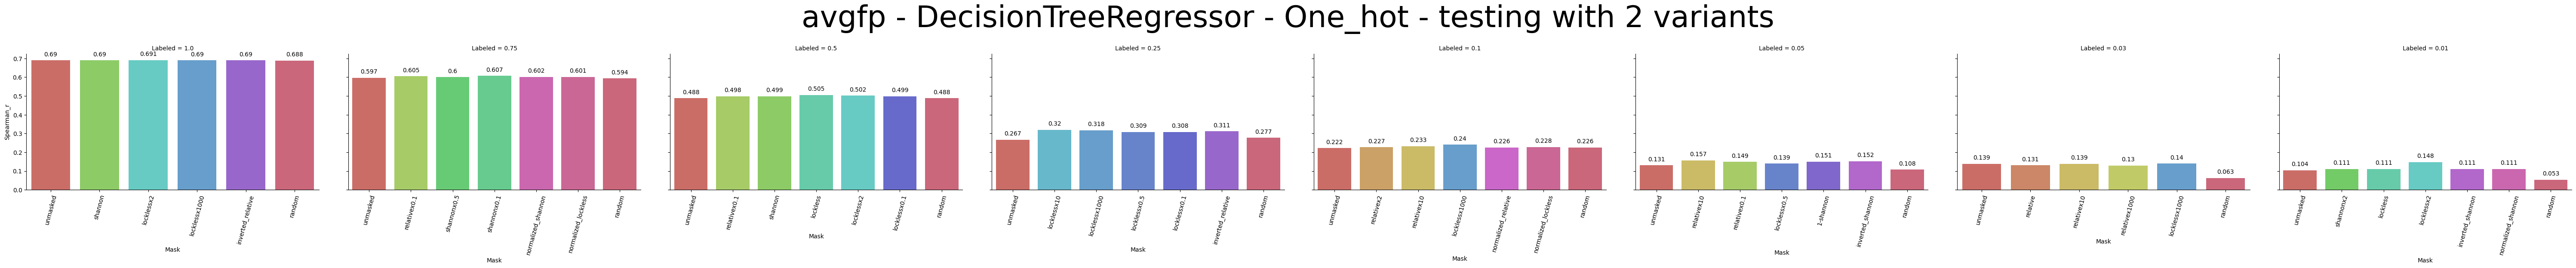

<Figure size 2500x500 with 0 Axes>

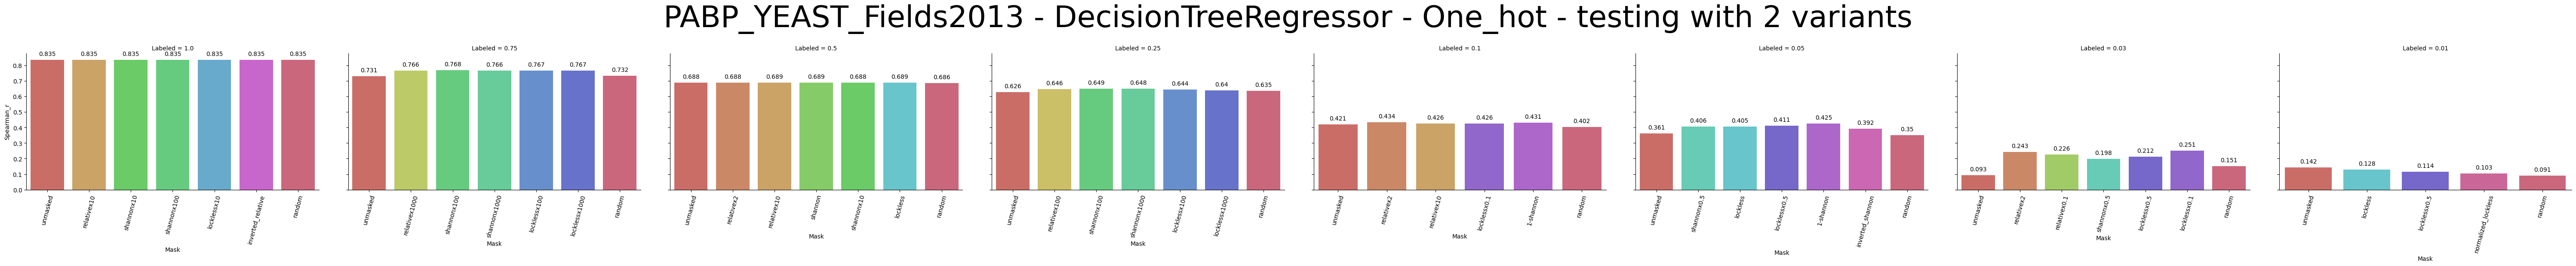

<Figure size 2500x500 with 0 Axes>

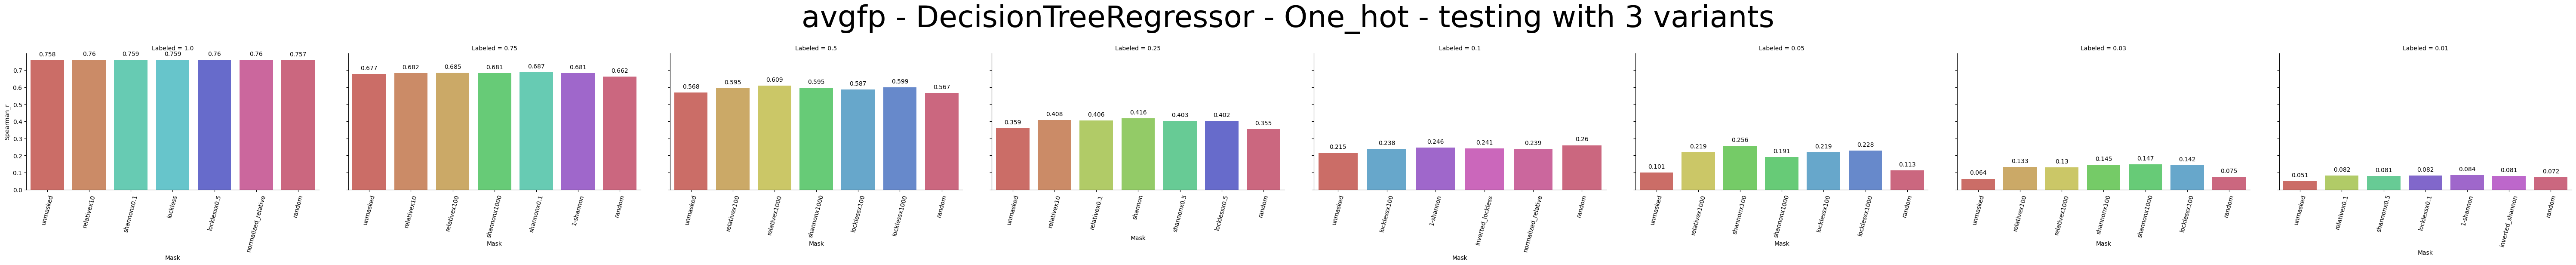

<Figure size 2500x500 with 0 Axes>

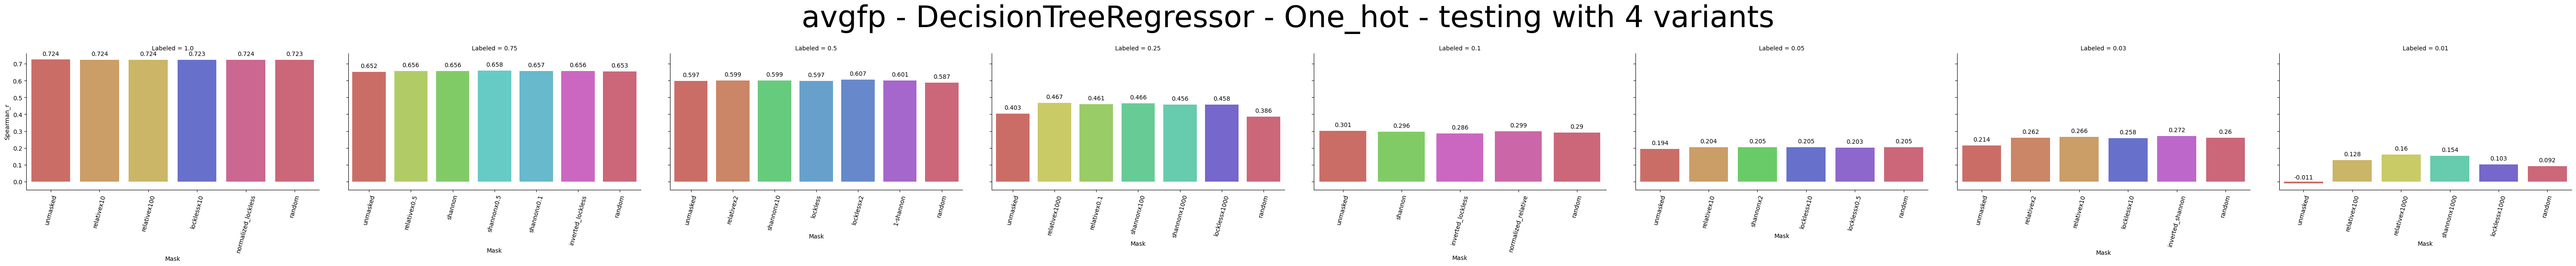

<Figure size 2500x500 with 0 Axes>

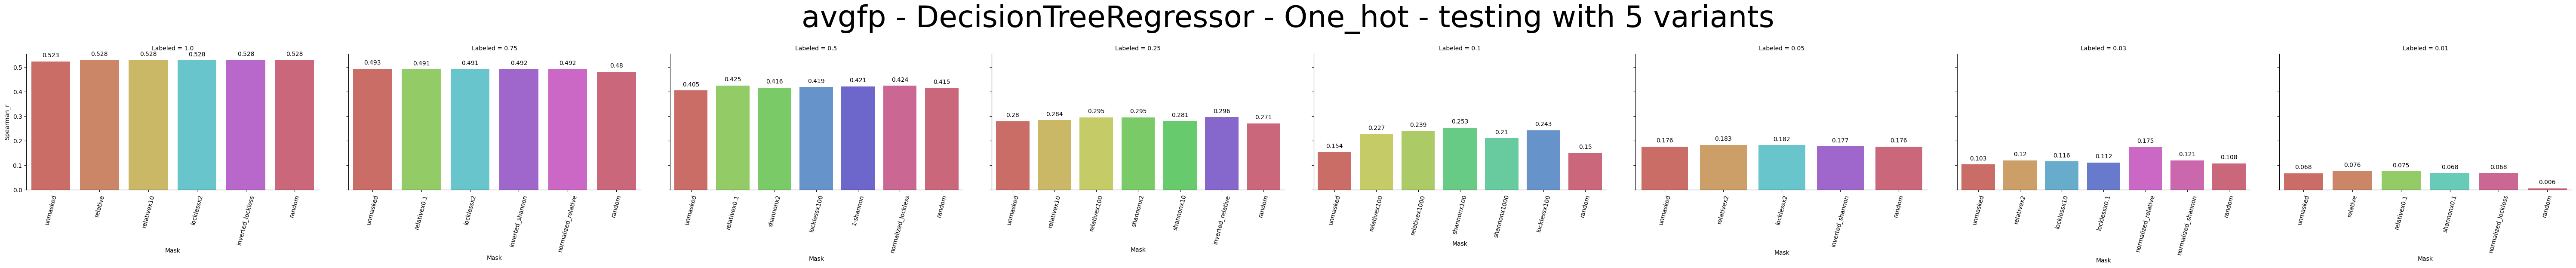

<Figure size 2500x500 with 0 Axes>

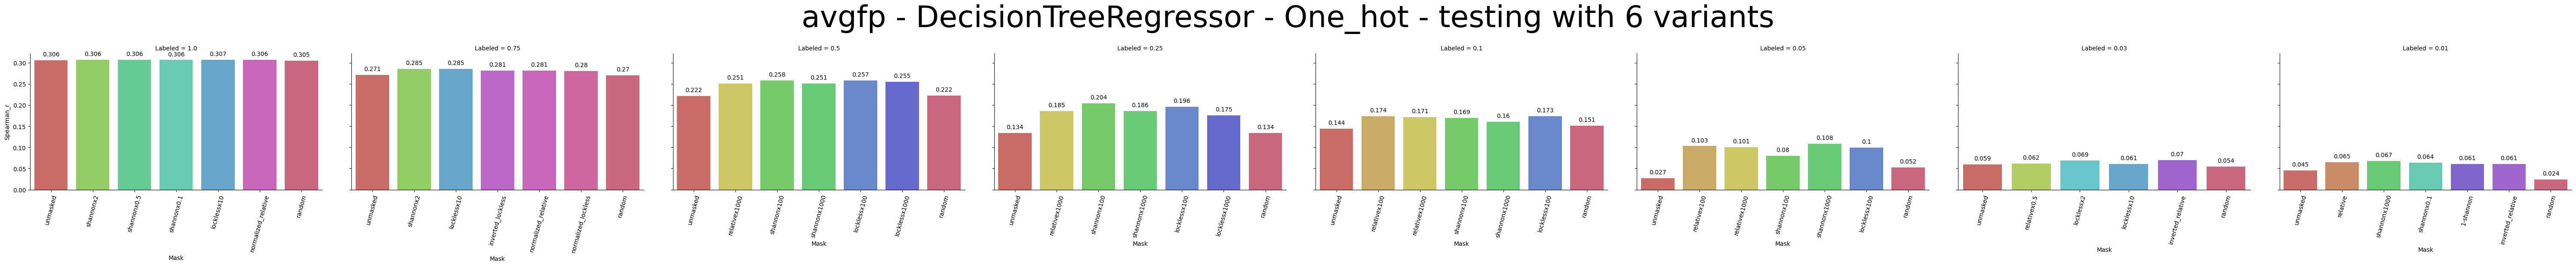

<Figure size 2500x500 with 0 Axes>

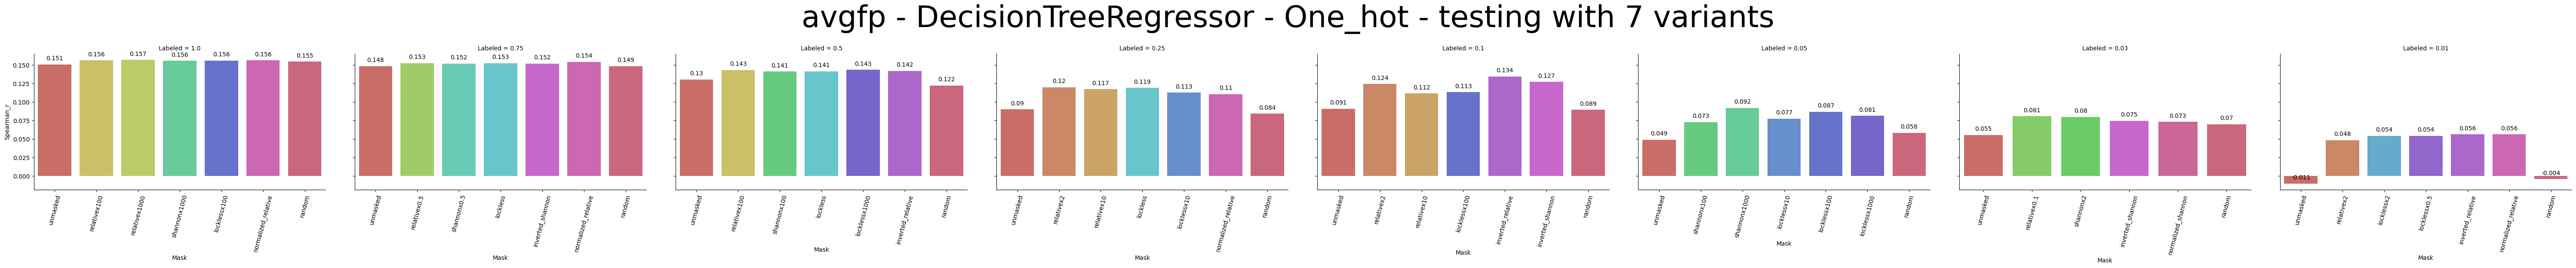

<Figure size 2500x500 with 0 Axes>

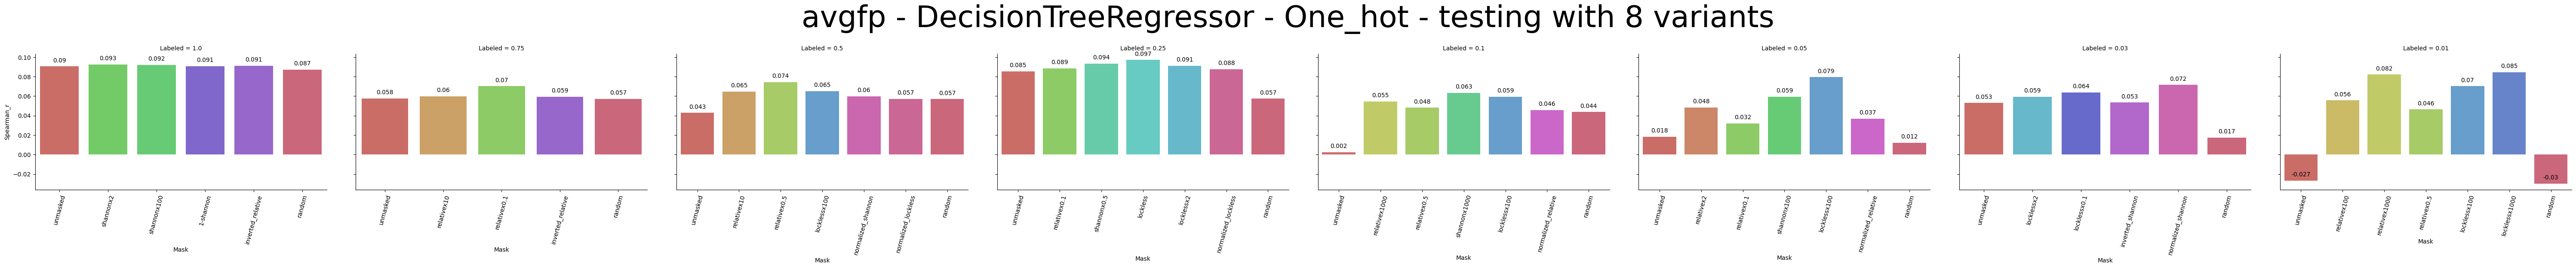

<Figure size 2500x500 with 0 Axes>

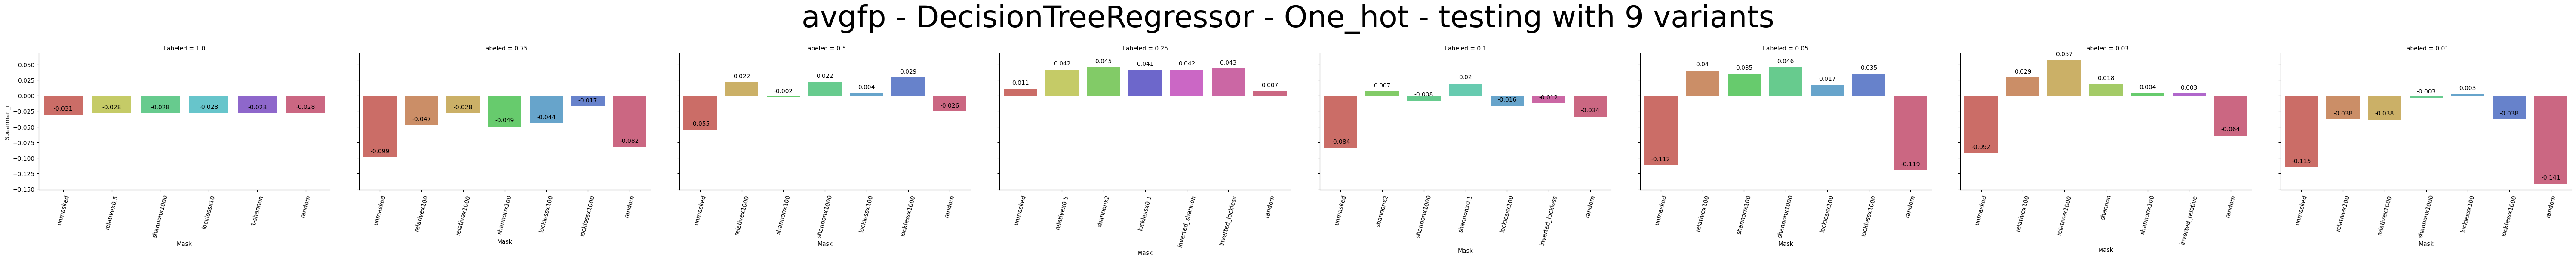

<Figure size 2500x500 with 0 Axes>

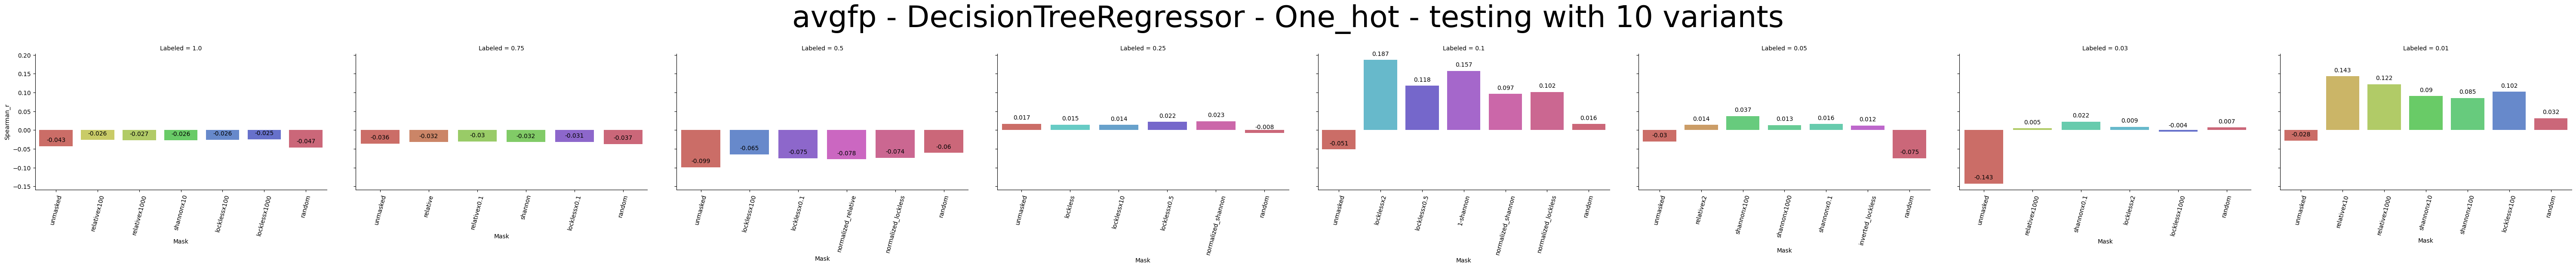

In [21]:
# Plot for every pair Dataset/Test N variants
for dataset, test_N_variants in df[['Dataset', 'Test N variants']].drop_duplicates().sort_values(by="Test N variants").values:
    # Now do the same buy in a single plot grouping the masks by labeled_size
    plt.figure(figsize=(25, 5))

    plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Test N variants"] == test_N_variants)]

    # Remove the empty bars in the plot
    g = sns.catplot(kind='bar',
                data=plt_df,
                col='Labeled',
                x='Mask', 
                y=metric,
                hue='Mask', dodge=False, sharex=False,
                height=5, aspect=1.5, legend_out=False,
                col_order=sorted(df[df["Encoding"] == encoding]["Labeled"].unique(), reverse=True),
                palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                )
    # Show values on top of the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Put the groups closer
    g.fig.subplots_adjust(wspace=0.1)
    # Title
    g.fig.suptitle(f'{dataset} - {model} - {encoding} - testing with {test_N_variants} variants', fontsize=50)
    # Some space below the title
    g.fig.subplots_adjust(top=0.75)

    # Tilt the x labels 75 degrees
    g.set_xticklabels(rotation=75)

    plt.show()

In [22]:
# Fixed parameters
encoding = "One_hot"
model = "StandardScaler_DecisionTreeRegressor"
metric = "Spearman_r" # Spearman_r Weighted_tau MSE RMSE

<Figure size 2500x500 with 0 Axes>

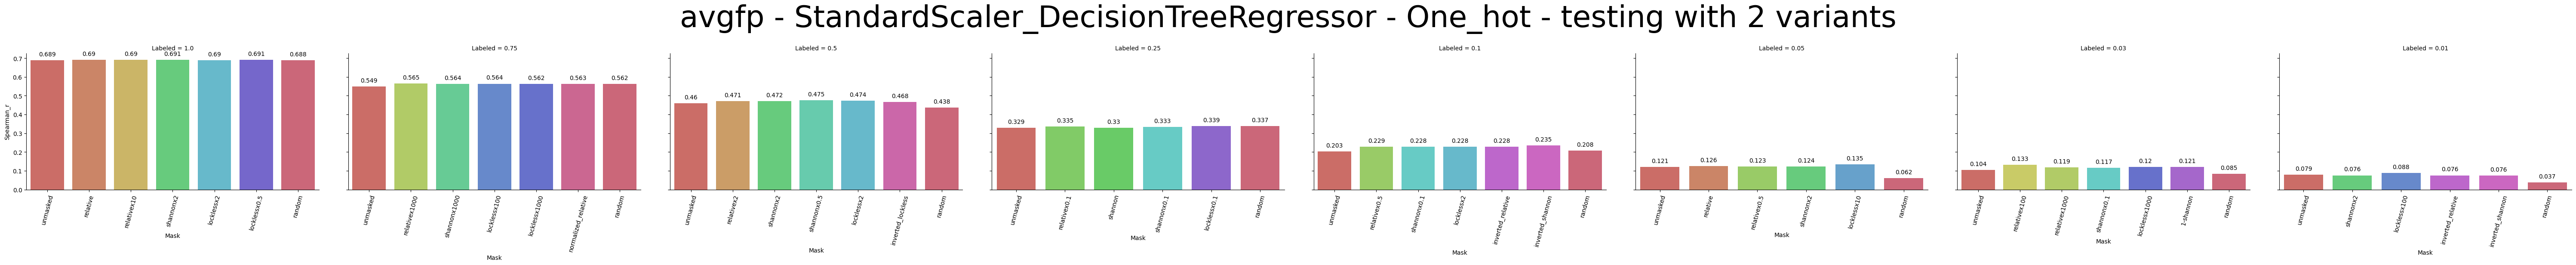

<Figure size 2500x500 with 0 Axes>

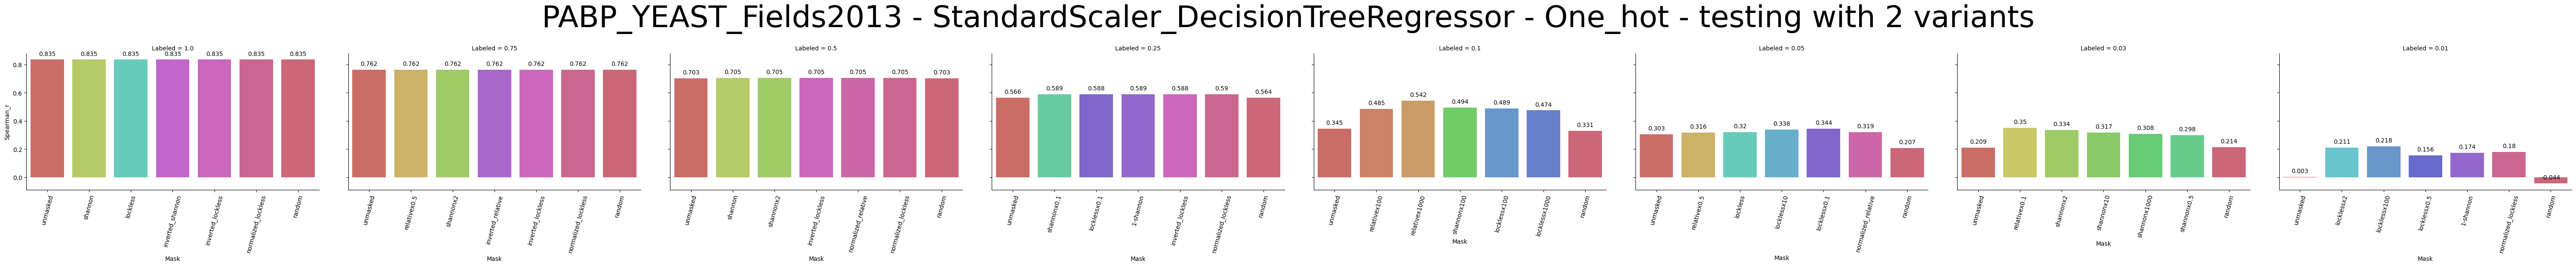

<Figure size 2500x500 with 0 Axes>

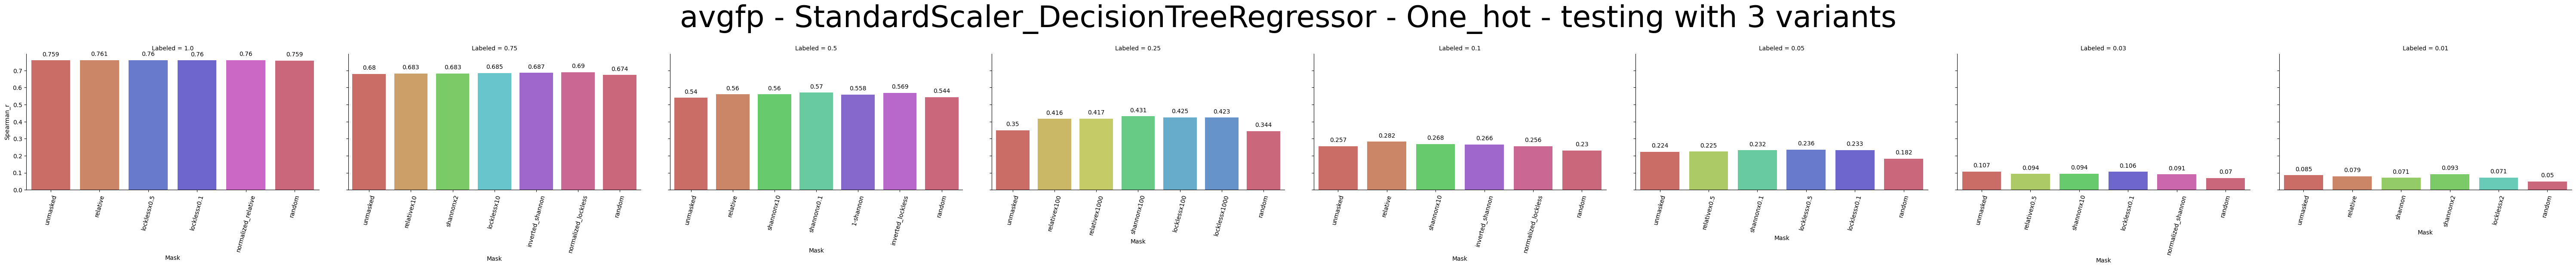

<Figure size 2500x500 with 0 Axes>

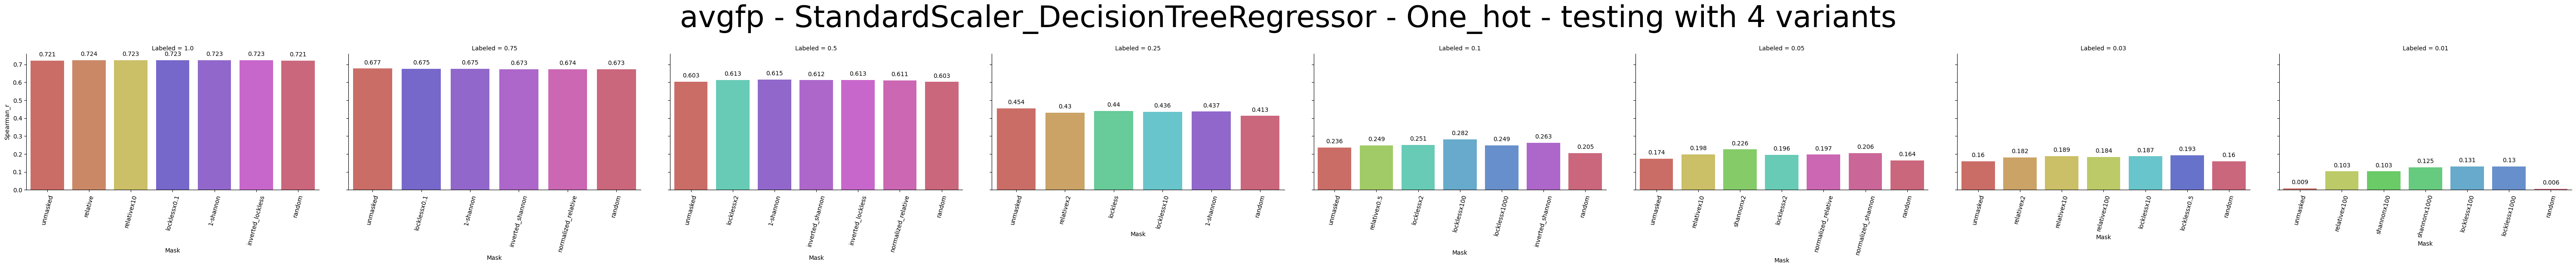

<Figure size 2500x500 with 0 Axes>

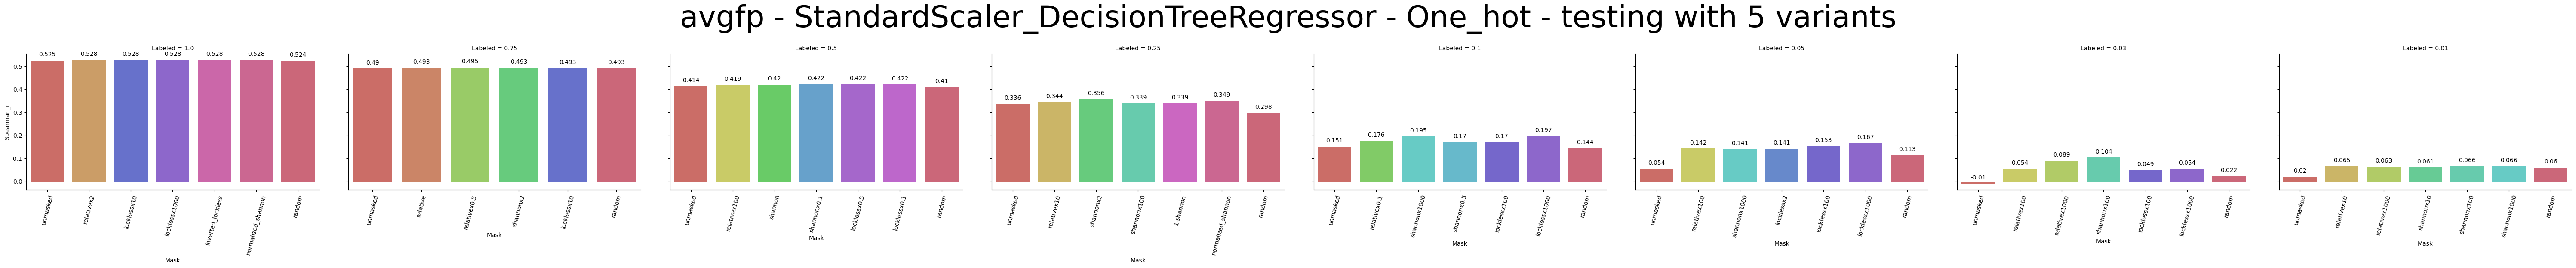

<Figure size 2500x500 with 0 Axes>

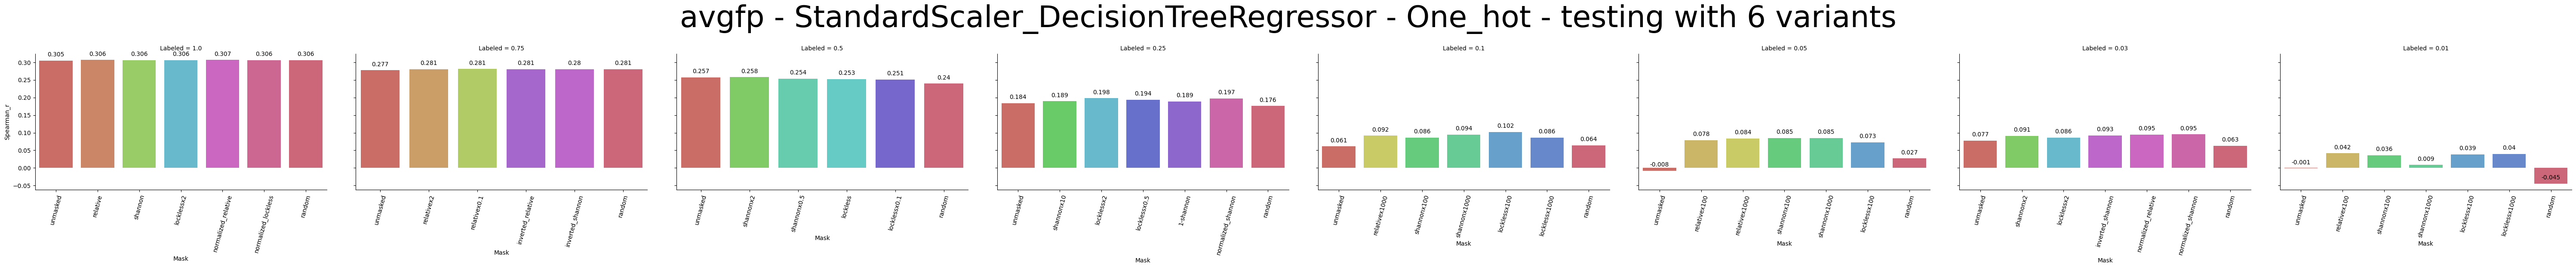

<Figure size 2500x500 with 0 Axes>

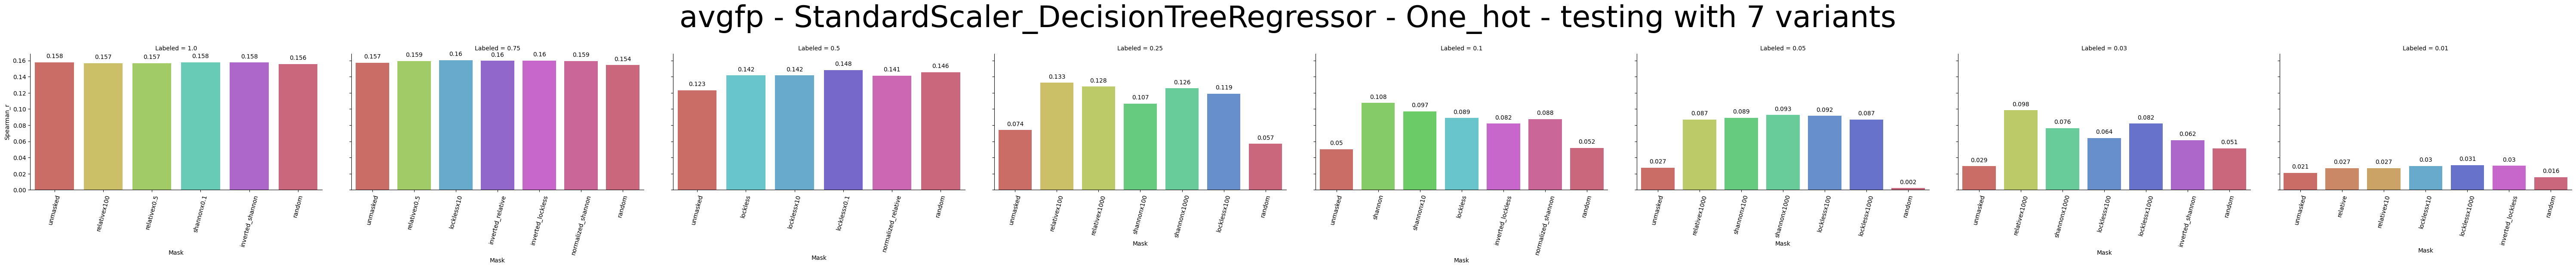

<Figure size 2500x500 with 0 Axes>

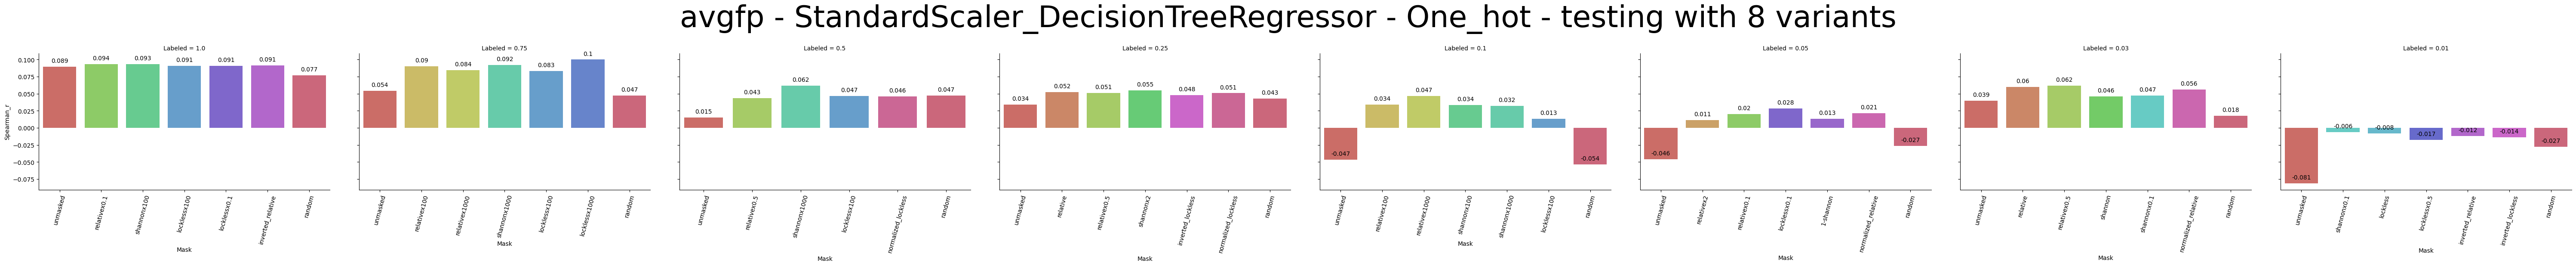

<Figure size 2500x500 with 0 Axes>

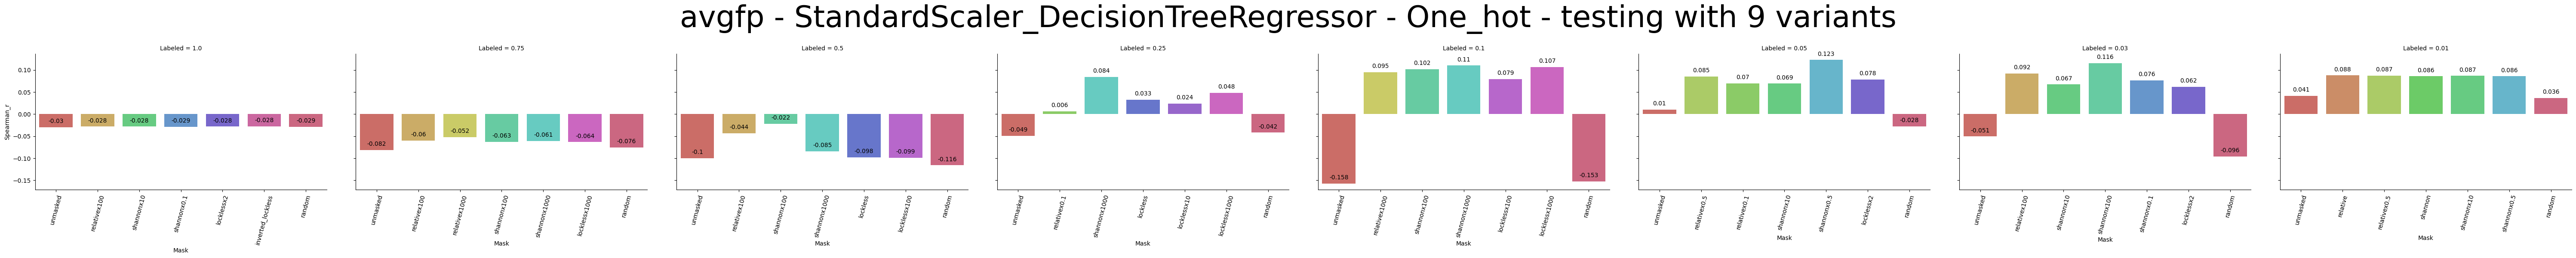

<Figure size 2500x500 with 0 Axes>

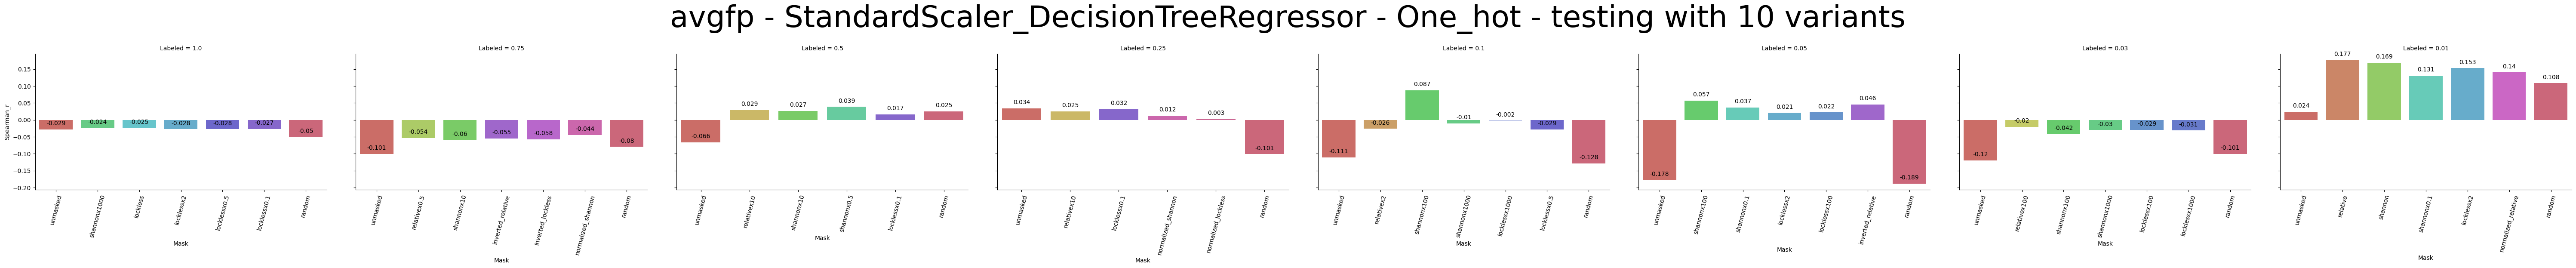

In [23]:
# Plot for every pair Dataset/Test N variants
for dataset, test_N_variants in df[['Dataset', 'Test N variants']].drop_duplicates().sort_values(by="Test N variants").values:
    # Now do the same buy in a single plot grouping the masks by labeled_size
    plt.figure(figsize=(25, 5))

    plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Test N variants"] == test_N_variants)]
    # Remove the empty bars in the plot
    g = sns.catplot(kind='bar',
                data=plt_df,
                col='Labeled',
                x='Mask', 
                y=metric,
                hue='Mask', dodge=False, sharex=False,
                height=5, aspect=1.5, legend_out=False,
                col_order=sorted(df[df["Encoding"] == encoding]["Labeled"].unique(), reverse=True),
                palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                )
    # Show values on top of the bars
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Put the groups closer
    g.fig.subplots_adjust(wspace=0.1)
    # Title
    g.fig.suptitle(f'{dataset} - {model} - {encoding} - testing with {test_N_variants} variants', fontsize=50)
    # Some space below the title
    g.fig.subplots_adjust(top=0.75)

    # Tilt the x labels 75 degrees
    g.set_xticklabels(rotation=75)

    plt.show()

In [24]:
# Fixed parameters
encoding = "One_hot"
labeled_size = 1
test_N_variants = 2

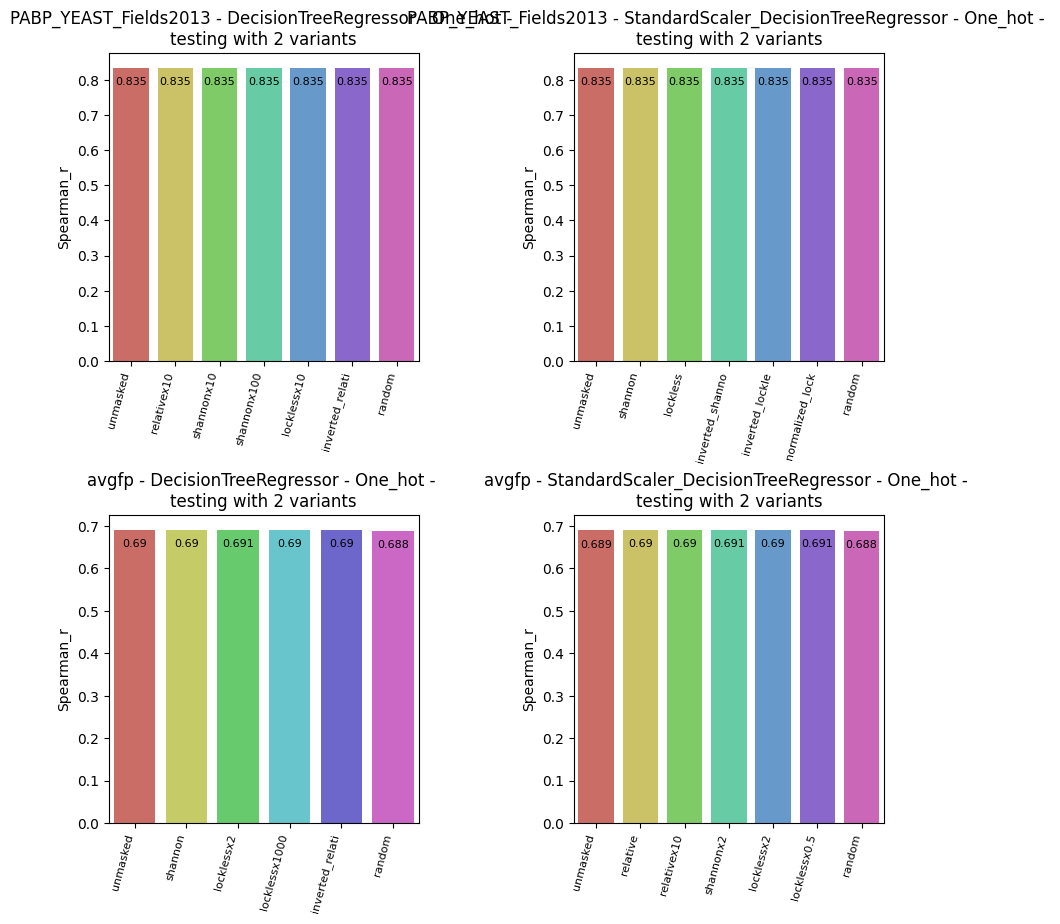

In [25]:
# Subplot catplot for every dataset/model pair
number_of_datasets = len(df[df["Encoding"] == encoding]["Dataset"].unique())
number_of_models = len(df[df["Encoding"] == encoding]["Model"].unique())
fig, axs = plt.subplots(number_of_datasets, number_of_models, figsize=(number_of_models*5, number_of_datasets*5))
for i, dataset in enumerate(sorted(df[df["Encoding"] == encoding]["Dataset"].unique())):
    for j, model in enumerate(sorted(df[df["Encoding"] == encoding]["Model"].unique())):

        # Now do the same buy in a single plot grouping the masks by labeled_size
        plt_df = df[(df["Encoding"] == encoding) & (df["Model"] == model) & (df["Dataset"] == dataset) & (df["Labeled"] == labeled_size) & (df["Test N variants"] == test_N_variants)]

        # Remove the empty bars in the plot
        g = sns.barplot(data=plt_df,
                    x='Mask', 
                    y=metric,
                    hue='Mask', dodge=False, 
                    ax=axs[i, j],
                    palette=sns.color_palette("hls", len(plt_df["Mask"].unique())).copy()
                    )
        # Show values at the top of the bars (inside them)
        for p in g.patches:
            g.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, -10), textcoords='offset points', fontsize=8)
        # Title
        g.set_title(f'{dataset} - {model} - {encoding} - \ntesting with {test_N_variants} variants', fontsize=12)
        
        # Hide x labels
        g.set_xlabel("")
        
        # Tilt the x labels 75 degrees
        g.set_xticklabels(g.get_xticklabels(), rotation=75, ha="right", fontsize=8)
        # x labels sometimes are too long so we need to shorten them
        g.set_xticklabels([x.get_text()[:15] for x in g.get_xticklabels()])
        # Remove the legend
        g.get_legend().remove()
        # More space between the subplots
        fig.subplots_adjust(hspace=0.5, wspace=0.5)